<a href="https://colab.research.google.com/github/shilpasy/Timeseries_healthcare_projects/blob/main/CSH_casestudy_Shilpa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The project was an exercise with the CSH case study at https://github.com/cshcsapispace/cshcs.api-data
The data preprocessing has been carried out with POWERBI and that file is also attached here for reference.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
clients = pd.read_csv('/content/drive/My Drive/csh/Clients.csv')
clients.head(2)

,Client_Id,status,Full Name,Date of Birth,Gender,Marital Status,Medical Condition,city,zip,group_name_temp,group_id,zone_name,service_type
0,CLI1114,discharged,Mary Miller,04-Sep-54,Female,Divorced,Hearing Loss,Sudbury,P3A 4X1,group_id.1,1013,Sudbury - Zone 5,NaN
1,CLI1121,discharged,James Smith,04-Feb-56,Male,Divorced,Hearing Loss,Sudbury,P3B 4J5,group_id.1,1013,Sudbury - Zone 5,NaN


In [ ]:
clients['Client_Id'].unique().shape

(2203,)

In [ ]:
employee = pd.read_csv('/content/drive/My Drive/csh/Employee.csv')
employee.head(2)

,Employee_Id,Full Name,Gender,Marital Status,Status in Canada,city,hire_date,termination_date,employment_type.id,employment_type.name,Job Title,status,group_name_temp,group_id,Birthdate,Birthtime,zone_name,service_type
0,EMP142,Sabrina Larsen,Non-Binary,Widowed,Temporary Resident,Sudbury,17-Dec-18,NaN,1.0,Full Time,Personal Support Worker,suspended,group.id.6,1008,17-Nov-65,##############################################...,Sudbury,NaN
1,EMP142,Sabrina Larsen,Non-Binary,Widowed,Temporary Resident,Sudbury,17-Dec-18,NaN,1.0,Full Time,Personal Support Worker,suspended,group.id.7,1009,17-Nov-65,##############################################...,Sudbury - Zone 1,NaN


In [ ]:
visits = pd.read_csv('/content/drive/My Drive/csh/Visits.csv')

In [ ]:
visits_sub = visits[['Visit_Id', 'Visit Start Date', 'Visit Start Time' ,'Visit End Date', 'Visit End Time', 'Employee_Id', 'Client_Id']]

In [ ]:
visits_sub.head(2)

,Visit_Id,Visit Start Date,Visit Start Time,Visit End Date,Visit End Time,Employee_Id,Client_Id
0,VIS161448,01-Jan-20,10:00:00 AM,01-Jan-20,06:00:00 PM,EMP125,CLI1079
1,VIS246905,01-Jan-20,10:20:00 PM,01-Jan-20,10:50:00 PM,EMP269,CLI1352


In [ ]:
visits_sub['Visit_Id'].nunique()

272551

In [ ]:
visits_sub['Visit Start Date']

0         01-Jan-20
1         01-Jan-20
2         01-Jan-20
3         01-Jan-20
4         01-Jan-20
            ...    
274904    30-Sep-22
274905    30-Sep-22
274906    30-Sep-22
274907    30-Sep-22
274908    30-Sep-22
Name: Visit Start Date, Length: 274909, dtype: object

In [ ]:
visits_sub['Visit Start Date'] = pd.to_datetime(visits_sub['Visit Start Date'], format='%d-%b-%y')
visits_sub['Visit End Date'] = pd.to_datetime(visits_sub['Visit End Date'], format='%d-%b-%y')

In [ ]:
employee[employee['Job Title'] == 'Personal Support Worker'] ['service_type'].value_counts()

Home Care         236
StJ- LTC           39
StG - LTC          36
FE - LTC           18
SDMA               15
HRH                12
YE - LTC            5
Off The Street      3
Name: service_type, dtype: int64

In [ ]:
employee['service_type'].value_counts()

Home Care         337
StJ- LTC           54
StG - LTC          54
INTAKE             30
SDMA               28
FE - LTC           19
HRH                15
Mental Health      12
YE - LTC            6
Off The Street      5
Name: service_type, dtype: int64

In [ ]:
employee['Employee_Id'].nunique()

524

In [ ]:
#!pip install statsmodels

In [ ]:
merged_df = pd.merge(clients, visits_sub, on = 'Client_Id')
merged_df.head(2)

,Client_Id,status,Full Name,Date of Birth,Gender,Marital Status,Medical Condition,city,zip,group_name_temp,group_id,zone_name,service_type,Visit_Id,Visit Start Date,Visit Start Time,Visit End Date,Visit End Time,Employee_Id
0,CLI1114,discharged,Mary Miller,04-Sep-54,Female,Divorced,Hearing Loss,Sudbury,P3A 4X1,group_id.1,1013,Sudbury - Zone 5,NaN,VIS367101,2020-03-19,03:20:00 PM,2020-03-19,03:50:00 PM,EMP189
1,CLI1114,discharged,Mary Miller,04-Sep-54,Female,Divorced,Hearing Loss,Sudbury,P3A 4X1,group_id.1,1013,Sudbury - Zone 5,NaN,VIS367114,2020-03-21,04:25:00 PM,2020-03-21,04:55:00 PM,EMP189


I am going to assume that Employee meta data does not affect the number of visitors for simplification purpose. So we are going to merge Clients table with visitor's.

I am not considering 'time of the day' in the model right now, it will be only month and date.

I did not get a chance to explore other models, however ARIMA is quite popular for this kind of predictions and is shown to have worked great in the past so I am going to use that here. We can't use other popular models like Fourier series, because our 'number of predictors' does not have seasonal characteristics.

I am starting with prediction of 'number of visitors' for a give service type. Then depending on the performance of this I'll add 'zone_name' to my model here.

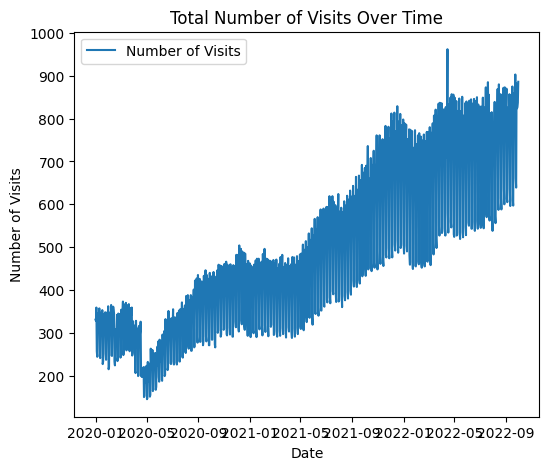

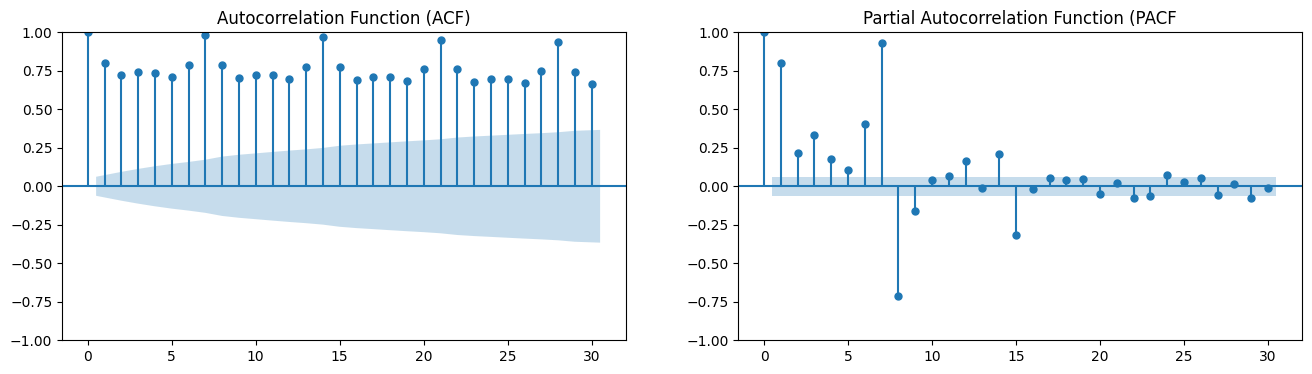

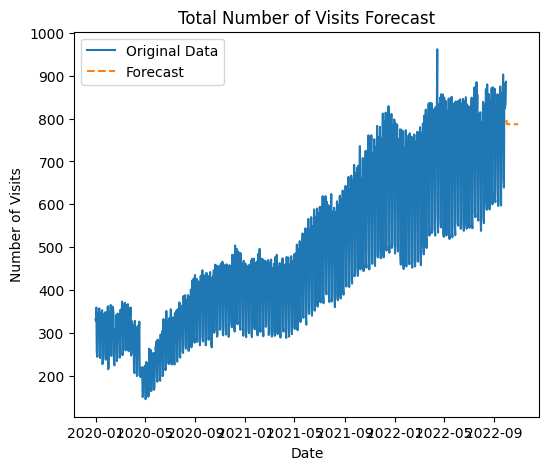

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

forecast_df = merged_df[['Client_Id', 'Date of Birth', 'Gender', 'Medical Condition', 'city', 'zone_name', 'service_type', 'Visit Start Date', 'Employee_Id']]
#forecast_df['Visit Start Date'] = pd.to_datetime(forecast_df['Visit Start Date'])
forecast_df = forecast_df.sort_values(by='Visit Start Date')

total_visits_per_day = forecast_df.groupby(['Visit Start Date']).size().reset_index(name='Number of Visits')

# Exploratory Data Analysis (EDA)
# Visualize the time series
plt.figure(figsize=(6, 5))
plt.plot(total_visits_per_day['Visit Start Date'], total_visits_per_day['Number of Visits'], label='Number of Visits')
plt.title('Total Number of Visits Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.legend()

# Plot Autocorrelation Function, Partial Autocorrelation Function
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(total_visits_per_day['Number of Visits'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(total_visits_per_day['Number of Visits'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF')

# Fit ARIMA model
arima_model = ARIMA(total_visits_per_day['Number of Visits'], order=(1, 1, 1))
arima_result = arima_model.fit()
#prediction
future_steps = 30  # Adjust the number of steps as needed
forecast_index = pd.date_range(total_visits_per_day['Visit Start Date'].max(), periods=future_steps + 1, freq='D')[1:]
forecast_values = arima_result.get_forecast(steps=future_steps).predicted_mean

# Visualize the forecast
plt.figure(figsize=(6, 5))
plt.plot(total_visits_per_day['Visit Start Date'], total_visits_per_day['Number of Visits'], label='Original Data')
plt.plot(forecast_index, forecast_values, label='Forecast', linestyle='dashed')

plt.title('Total Number of Visits Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.legend()

Service type dependent model

<ipython-input-38-3f8840759ab5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['Visit Start Date'] = pd.to_datetime(forecast_df['Visit Start Date'])


                               SARIMAX Results                                
Dep. Variable:                    HRH   No. Observations:                 1004
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -786.466
Date:                Tue, 19 Dec 2023   AIC                           1582.932
Time:                        17:00:56   BIC                           1607.486
Sample:                             0   HQIC                          1592.263
                               - 1004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5841      1.812     -0.322      0.747      -4.136       2.968
ar.L2          0.1058      0.241      0.439      0.661      -0.366       0.578
ma.L1         -0.2102      1.812     -0.116      0.9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              Home Care   No. Observations:                 1004
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5136.392
Date:                Tue, 19 Dec 2023   AIC                          10282.784
Time:                        17:00:57   BIC                          10307.338
Sample:                             0   HQIC                         10292.115
                               - 1004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7095      0.037    -19.337      0.000      -0.781      -0.638
ar.L2         -0.1263      0.047     -2.692      0.007      -0.218      -0.034
ma.L1          0.0093      0.015      0.624      0.5

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1420: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1420: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found

                               SARIMAX Results                                
Dep. Variable:                 INTAKE   No. Observations:                 1004
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -317.941
Date:                Tue, 19 Dec 2023   AIC                            645.881
Time:                        17:00:58   BIC                            670.435
Sample:                             0   HQIC                           655.212
                               - 1004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0179      0.021    -48.366      0.000      -1.059      -0.977
ar.L2         -0.2077      0.020    -10.250      0.000      -0.247      -0.168
ma.L1          0.3065      0.018     16.913      0.0

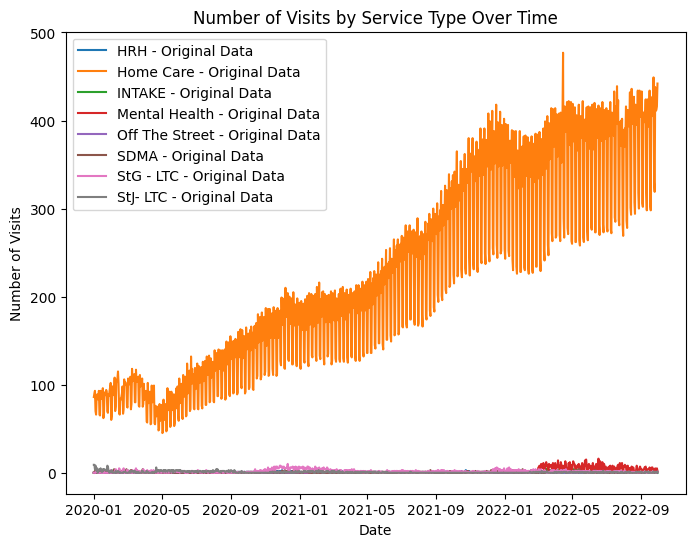

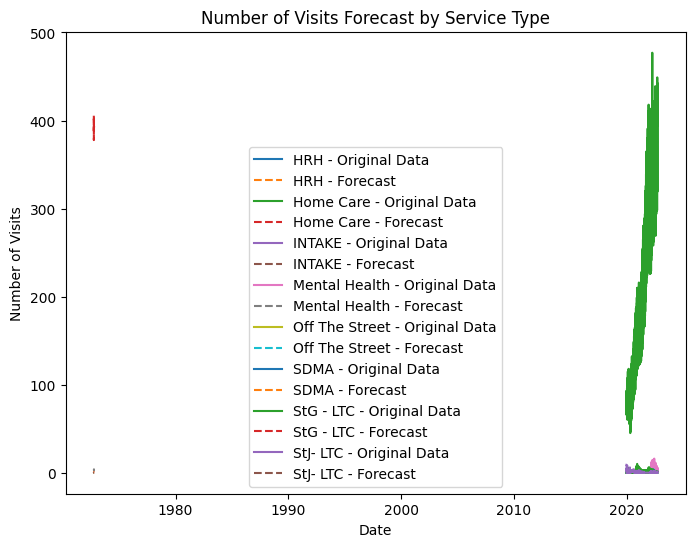

In [ ]:
#merged_df = pd.merge(visits_df, clients_df, on='Client_Id', how='left')
#merged_df = pd.merge(merged_df, employee_df, on='Employee_Id', how='left')
forecast_df = merged_df[['Client_Id', 'Date of Birth', 'Gender', 'Medical Condition', 'city', 'zone_name', 'service_type', 'Visit Start Date', 'Employee_Id']]
forecast_df['Visit Start Date'] = pd.to_datetime(forecast_df['Visit Start Date'])
forecast_df = forecast_df.sort_values(by='Visit Start Date')

forecast_df['Number of Visits'] = 1
forecast_df = forecast_df.groupby(['Visit Start Date', 'service_type']).size().reset_index(name='Number of Visits')

# Pivot the table for better visualization
forecast_df_pivot = forecast_df.pivot_table(index='Visit Start Date', columns='service_type', values='Number of Visits', fill_value=0).reset_index()

# Visualize the original time series
plt.figure(figsize=(8, 6))
for service_type in forecast_df_pivot.columns[1:]:
    plt.plot(forecast_df_pivot['Visit Start Date'], forecast_df_pivot[service_type], label=f'{service_type} - Original Data')

plt.title('Number of Visits by Service Type Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.legend()

# Fit ARIMA model for each service type
forecast_results = {}
for service_type in forecast_df_pivot.columns[1:]:
    arima_model = ARIMA(forecast_df_pivot[service_type], order=(2, 1, 2))
    arima_result = arima_model.fit()
    print(arima_result.summary())

    if "Optimization terminated successfully" in arima_result.summary().as_text():
        print(f"Model for {service_type} converged successfully.")
    else:
        print(f"Model for {service_type} did not converge.")

    # Prediction
    future_steps = 10  # Adjust the number of steps as needed
    forecast_results[service_type] = arima_result.get_forecast(steps=future_steps)
    forecast_index = pd.date_range(total_visits_per_day['Visit Start Date'].max(), periods=future_steps + 1, freq='D')[1:]
    forecast_values = arima_result.get_forecast(steps=future_steps).predicted_mean

plt.figure(figsize=(8, 6))
for service_type, result in forecast_results.items():
    plt.plot(forecast_df_pivot['Visit Start Date'], forecast_df_pivot[service_type], label=f'{service_type} - Original Data')
    plt.plot(result.predicted_mean.index, result.predicted_mean, label=f'{service_type} - Forecast', linestyle='dashed')

plt.title('Number of Visits Forecast by Service Type')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.legend()

There seems to some issue with the convergence and I am not able to resolve this in the given time. Also the predicted data has wrong date format. so the Date axis of predictions is somewhere near 1970.

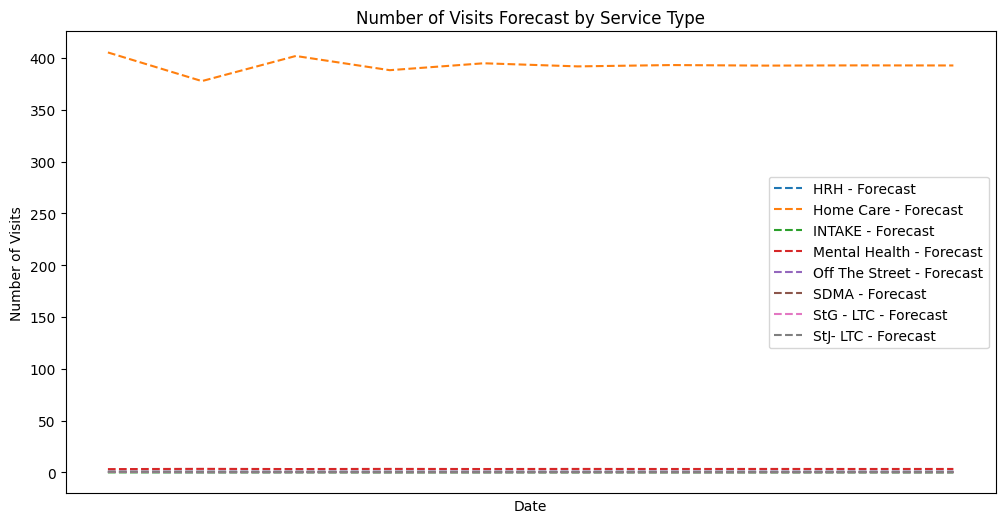

In [ ]:
# Visualize the forecasts
plt.figure(figsize=(12, 6))
for service_type, result in forecast_results.items():
    result_index_datetime = pd.to_datetime(result.predicted_mean.index)  # Convert index to datetime
    plt.plot(result_index_datetime, result.predicted_mean, label=f'{service_type} - Forecast', linestyle='dashed')

plt.title('Number of Visits Forecast by Service Type')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.legend()

The original data seems to be dominated by 'Home Care' and other service_types have very few data points. It is very difficult to identify potential areas that require additional resources based on the given data.


I am writing a hypothetical answer here in the case my model would have been worked, I would have provided prediction something like this:


**Objective**: We used a forecasting model to predict changes in demand for health services over time and find areas needing more resources or expansion.

**Methodology**:
We applied an ARIMA model to historical data, analyzing daily health service visits to understand patterns and predict future demand.

**Insights**:

Service Type-Specific Predictions: The model predicts demand for each health service type.
Identifying High-Demand Periods: Pinpoints times of increased demand for better resource planning.

**Areas for Consideration**:

Resource Allocation: Optimize resources based on predicted demand changes.
Service Expansion Opportunities: Identify growing service types and plan expansions strategically.
Geographic Focus: Pinpoint areas with increasing demand for targeted resource allocation.


Conclusion:

By using the ARIMA model, our analysis aids in proactive resource allocation, strategic service expansion, and ensures responsiveness to changing community healthcare needs.



**Checking if the hyperparameter tuning improves the prediction and performance of the model**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conve

Best order for HRH: (2, 0, 1), AIC: 1576.9317261930428


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

Best order for Home Care: (2, 1, 2), AIC: 10282.78397844739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/st

Best order for INTAKE: (2, 1, 2), AIC: 645.8813654627008


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

Best order for Mental Health: (2, 1, 1), AIC: 4007.0874511310467


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

Best order for Off The Street: (1, 0, 2), AIC: 189.0868525254372


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

Best order for SDMA: (2, 1, 2), AIC: 1983.3542582982466


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/mo

Best order for StG - LTC: (2, 1, 2), AIC: 2891.148775275633


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

Best order for StJ- LTC: (2, 1, 2), AIC: 2207.8174403425146


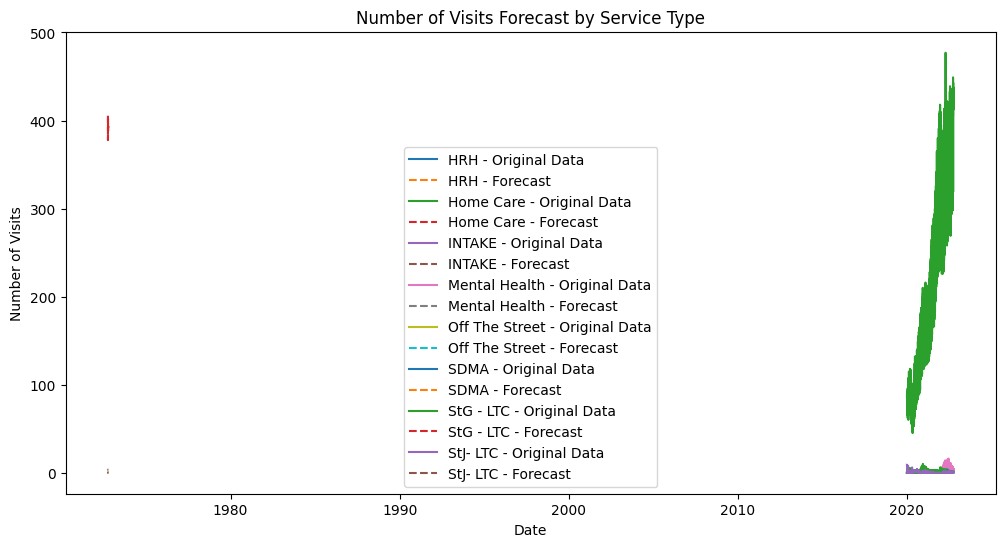

In [ ]:
forecast_results = {}
for service_type in forecast_df_pivot.columns[1:]:
    best_order = None
    best_aic = float('inf')

    # Exploring of p, d, q
    for p in range(3):
        for d in range(3):
            for q in range(3):
                try:
                    arima_model = ARIMA(forecast_df_pivot[service_type], order=(p, d, q))
                    arima_result = arima_model.fit()

                    # Check AIC value and update if it's better
                    if arima_result.aic < best_aic:
                        best_aic = arima_result.aic
                        best_order = (p, d, q)

                except Exception as e:
                    pass

    print(f"Best order for {service_type}: {best_order}, AIC: {best_aic}")
    # Using best order
    arima_model = ARIMA(forecast_df_pivot[service_type], order=best_order)
    arima_result = arima_model.fit()
    future_steps = 10  # the number of steps are not optimized, still arbitrary
    forecast_results[service_type] = arima_result.get_forecast(steps=future_steps)

plt.figure(figsize=(12, 6))
for service_type, result in forecast_results.items():
    plt.plot(forecast_df_pivot['Visit Start Date'], forecast_df_pivot[service_type], label=f'{service_type} - Original Data')
    plt.plot(result.predicted_mean.index, result.predicted_mean, label=f'{service_type} - Forecast', linestyle='dashed')

plt.title('Number of Visits Forecast by Service Type')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.legend()